In [117]:
import pandas as pd
import numpy as np

file1_path = 'C:\\Users\\USER\\Desktop\\VS code\台新data\\file1.csv'
file2_path = 'C:\\Users\\USER\\Desktop\\VS code\台新data\\file2.csv'
file3_path = 'C:\\Users\\USER\\Desktop\\VS code\台新data\\file3.csv'

df1 = pd.read_csv(file1_path)
df2 = pd.read_csv(file2_path)
df3 = pd.read_csv(file3_path)


## 整合CSV

In [119]:
df1.columns = df1.columns.str.strip()
df2.columns = df2.columns.str.strip()
df3.columns = df3.columns.str.strip()


In [120]:
# 'srno_2'列作為df1和df3的索引，确保它们是字符串類型
df1.set_index('srno_2', inplace=True)
df3.set_index('srno_2', inplace=True)

# 將'srno_2'和'yyyymm'作為df2的多重索引
df2.set_index(['srno_2', 'yyyymm'], inplace=True)


In [121]:
# 將df2的索引重置為ˊ列以便於合併
df2_reset = df2.reset_index()

# 基于srno_2合併df1的數據到df2
# 注意：實際操作需要根據實際數據結構調整
merged_df = pd.merge(df2_reset, df1, on='srno_2', how='left')

# 重複上述步驟將df3的數據合併到merged_df中
merged_df = pd.merge(merged_df, df3, on='srno_2', how='left', suffixes=('', '_df3'))


## 刪除變數 + 轉換Y,N to 1,0

In [12]:
# 假設 merged_df 是最終合併的 DataFrame

# 刪除不必要的變數
# rs_prod_1_df3 是最終客戶有沒有進行申購， rs_prod_1 in df2 表示是在幾月申購
#prod_1跟prod_2雖然不是我們的目標，但可能有意義，先不drop
#merged_df.drop(['rs_prod_1_df3', 'rs_prod_2_df3','rs_prod_1','rs_prod_2'], axis=1, inplace=True)

# 接下來數據分割和模型訓練等後續步驟


+ 資料裡面只有Y跟0 : 

    + intr_13 行為/互動標籤_類別13   

    + intr_12 行為/互動標籤_類別12
    
    

+ 資料裡面只有Y跟空白：
    
    + YN_Web_Active 數位會員活躍度標籤
       
    + YN_secur 證券戶標籤
    
    + YN_SLR 是否為薪轉戶
    
    


In [122]:
#檢查缺失值

missing_columns = merged_df.isna().any()

missing_columns[missing_columns]


YN_Web_Active    True
YN_secur         True
YN_SLR           True
dtype: bool

In [ ]:
# 假設df是您的DataFrame

# 將'Y'轉換成1，將'0'和空白轉換成0
# 先去除列中值的前後空格

merged_df['intr_12'] = merged_df['intr_12'].str.strip().replace({'Y': 1, '0': 0}).fillna(0).astype(int)
merged_df['intr_13'] = merged_df['intr_13'].str.strip().replace({'Y': 1, '0': 0}).fillna(0).astype(int)

#XGBoost可以處理NAN，先不要轉換Nan為0
#merged_df['YN_Web_Active'] = merged_df['YN_Web_Active'].str.strip().replace({'Y': 1}).fillna(0).astype(int)
#merged_df['YN_secur'] = merged_df['YN_secur'].str.strip().replace({'Y': 1}).fillna(0).astype(int)
#erged_df['YN_SLR'] = merged_df['YN_SLR'].str.strip().replace({'Y': 1}).fillna(0).astype(int)

merged_df['YN_Web_Active'] = merged_df['YN_Web_Active'].str.strip().replace({'Y': 1})
merged_df['YN_SLR'] = merged_df['YN_SLR'].str.strip().replace({'Y': 1})
merged_df['YN_secur'] = merged_df['YN_secur'].str.strip().replace({'Y': 1})

# 現在每個指定的列都應該只包含整數1和0
print(merged_df[['intr_12','intr_13', 'YN_Web_Active', 'YN_secur', 'YN_SLR']])


In [112]:
# 匯出成csv
merged_df.to_csv('merged_df.csv', index=False)


In [133]:
#根據 srno_2 切割merge df train test set
from sklearn.model_selection import train_test_split
Index = df1.index
train, test = train_test_split(Index,test_size=0.2, random_state=42)
merged_df_train = merged_df[merged_df['srno_2'].isin(train)]
merged_df_test = merged_df[merged_df['srno_2'].isin(train)]

#確保我們train test集切割會不會過於失衡
ratio = np.sum(df3[df3.index.isin(train)]['rs_prod_3'] == 1)/np.sum(df3['rs_prod_3'] == 1)
print(ratio)

#接下來所有的操作都只在merge_df_train進行

0.8049787899084617


+ rs_prod   這個人每個月有沒有買

    + rs_prod_df3 這個人有沒有買

## XGboost


In [167]:
from xgboost import XGBClassifier
from sklearn import model_selection
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, auc,roc_auc_score

#執行10-Fold
kf = KFold(n_splits=10, shuffle=True, random_state=42)

y = merged_df_train["rs_prod_3"]
X = merged_df_train.drop(columns=['rs_prod_3'])

# 创建空列表，用于存储每个 fold 的评估结果
auc_scores = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model = XGBClassifier()
    
    model.fit(X_train, y_train)
    
    y_pred_proba = model.predict_proba(X_test)[:, 1] 

    auc = roc_auc_score(y_test, y_pred_proba)
    auc_scores.append(auc)

print("Average ROC-AUC:", sum(auc_scores) / len(auc_scores))


Average ROC-AUC: 0.9466804465190292


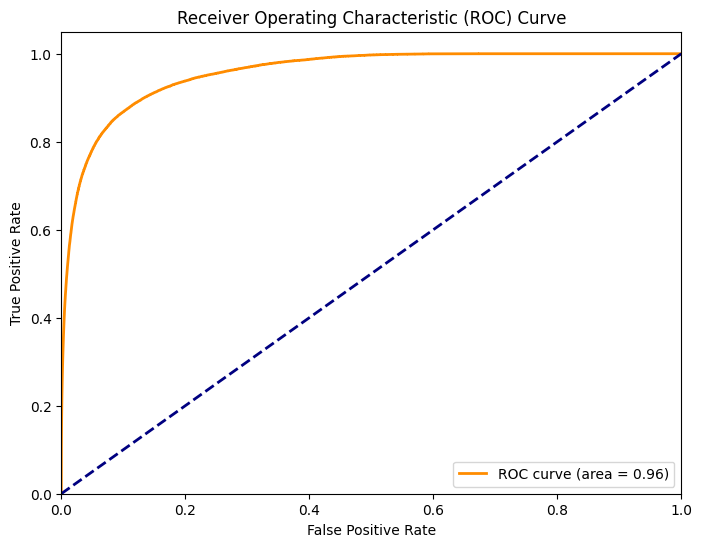

In [174]:
from sklearn.metrics import roc_curve, auc
y = merged_df_test["rs_prod_3"]
X = merged_df_test.drop(columns=['rs_prod_3'])
y_pred_proba = model.predict_proba(X)[:, 1] 

fpr, tpr, thresholds = roc_curve(y, y_pred_proba)

roc_auc = auc(fpr, tpr)

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

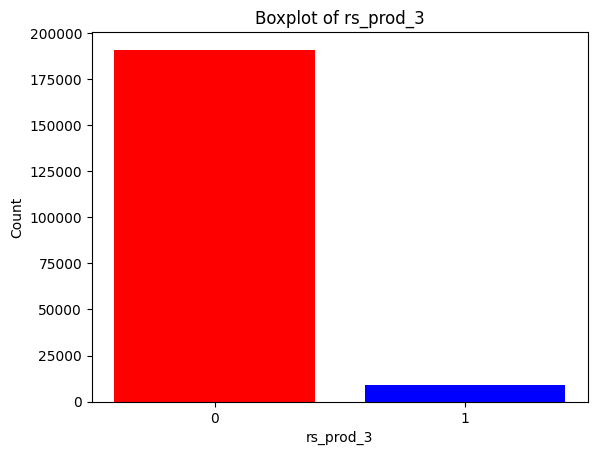

In [162]:
#Target distribution
counts = df3["rs_prod_3"].value_counts()

# 绘制箱线图
plt.bar(counts.index, counts.values,color =  ['r', 'b'])

# 添加标题和标签
plt.title("Boxplot of rs_prod_3")
plt.xlabel("rs_prod_3")
plt.ylabel("Count")
plt.xticks([0, 1], ["0", "1"])


plt.show()

#Ubalance data


## 隨機森林分析

In [ ]:
# pip install scikit-learn

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

merged_df = pd.read_csv('merged_df.csv')

# 分離特徵和目標變數
X = merged_df.drop(['rs_prod_3_df3'], axis=1)  # 特徵集
y = merged_df['rs_prod_3_df3']  # 目標變數

# 劃分訓練集和測試集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 初始化隨機森林回歸模型
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# 訓練模型
rf_model.fit(X_train, y_train)

# 進行預測
predictions = rf_model.predict(X_test)

# 評估模型
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)

print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
